### Importación de librerías

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
from sentence_transformers import SentenceTransformer, util
import tensorflow_hub as hub
from tensorflow_text import SentencepieceTokenizer
import sklearn.metrics.pairwise
from simpleneighbors import SimpleNeighbors
from tqdm import tqdm
from tqdm import trange
import tensorflow.compat.v2 as tf
import torch
import time
from unidecode import unidecode
import math
import faiss

### Configuracion notebook

In [2]:
pd.set_option('display.max_columns', None)  
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', 4000)

### Carga de modelos

In [3]:
model_minilm = SentenceTransformer('all-MiniLM-L6-v2')
model_mpnet = SentenceTransformer('all-mpnet-base-v2')
model_multilingual_distiluse_v1 = SentenceTransformer('distiluse-base-multilingual-cased-v1')
model_multilingual_distiluse_v2 = SentenceTransformer('distiluse-base-multilingual-cased-v2')
model_multilingual_minilm = SentenceTransformer('paraphrase-multilingual-MiniLM-L12-v2')
model_multilingual_mpnet = SentenceTransformer('paraphrase-multilingual-mpnet-base-v2')

model_use = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")
model_use_large = hub.load("https://tfhub.dev/google/universal-sentence-encoder-large/5")
model_use_multilingual = hub.load("https://tfhub.dev/google/universal-sentence-encoder-multilingual/3")
model_use_multilingual_large = hub.load("https://tfhub.dev/google/universal-sentence-encoder-multilingual-large/3")

## Generación e indexado de embeddings

In [4]:
def generate_embeddings(messages):
    result = []
    
    start_encoding = time.time()
    embeddings_minilm = model_minilm.encode(messages)
    end_encoding = time.time()
    start_indexing = time.time()
    index = faiss.IndexFlatL2(embeddings_minilm.shape[1])
    index.add(embeddings_minilm)
    faiss.write_index(index, './indexes/index_embeddings_minilm')
    end_indexing = time.time()
    result.append({"model": "minilm", "time_encoding": end_encoding - start_encoding, "time_indexing": end_indexing - start_indexing, "tensor": embeddings_minilm})

    start_encoding = time.time()
    embeddings_mpnet = model_mpnet.encode(messages)
    end_encoding = time.time()
    start_indexing = time.time()
    index = faiss.IndexFlatL2(embeddings_mpnet.shape[1])
    index.add(embeddings_mpnet)
    faiss.write_index(index, './indexes/index_embeddings_mpnet')
    end_indexing = time.time()
    result.append({"model": "mpnet", "time_encoding": end_encoding - start_encoding, "time_indexing": end_indexing - start_indexing, "tensor": embeddings_mpnet})

    start_encoding = time.time()
    embeddings_multilingual_distiluse_v1 = model_multilingual_distiluse_v1.encode(messages)
    end_encoding = time.time()
    start_indexing = time.time()
    index = faiss.IndexFlatL2(embeddings_multilingual_distiluse_v1.shape[1])
    index.add(embeddings_multilingual_distiluse_v1)
    faiss.write_index(index, './indexes/index_embeddings_multilingual_distiluse_v1')
    end_indexing = time.time()
    result.append({"model": "multilingual_distiluse_v1", "time_encoding": end_encoding - start_encoding, "time_indexing": end_indexing - start_indexing, "tensor": embeddings_multilingual_distiluse_v1})

    start_encoding = time.time()
    embeddings_multilingual_distiluse_v2 = model_multilingual_distiluse_v2.encode(messages)
    end_encoding = time.time()
    start_indexing = time.time()
    index = faiss.IndexFlatL2(embeddings_multilingual_distiluse_v2.shape[1])
    index.add(embeddings_multilingual_distiluse_v2)
    faiss.write_index(index, './indexes/index_embeddings_multilingual_distiluse_v2')
    end_indexing = time.time()
    result.append({"model": "multilingual_distiluse_v2", "time_encoding": end_encoding - start_encoding, "time_indexing": end_indexing - start_indexing, "tensor": embeddings_multilingual_distiluse_v2})

    start_encoding = time.time()
    embeddings_multilingual_minilm = model_multilingual_minilm.encode(messages)
    end_encoding = time.time()
    start_indexing = time.time()
    index = faiss.IndexFlatL2(embeddings_multilingual_minilm.shape[1])
    index.add(embeddings_multilingual_minilm)
    faiss.write_index(index, './indexes/index_embeddings_multilingual_minilm')
    end_indexing = time.time()
    result.append({"model": "multilingual_minilm", "time_encoding": end_encoding - start_encoding, "time_indexing": end_indexing - start_indexing, "tensor": embeddings_multilingual_minilm})

    start_encoding = time.time()
    embeddings_multilingual_mpnet = model_multilingual_mpnet.encode(messages)
    end_encoding = time.time()
    start_indexing = time.time()
    index = faiss.IndexFlatL2(embeddings_multilingual_mpnet.shape[1])
    index.add(embeddings_multilingual_mpnet)
    faiss.write_index(index, './indexes/index_embeddings_multilingual_mpnet')
    end_indexing = time.time()
    result.append({"model": "multilingual_mpnet", "time_encoding": end_encoding - start_encoding, "time_indexing": end_indexing - start_indexing, "tensor": embeddings_multilingual_mpnet})

    start_encoding = time.time()
    embeddings_use = model_use(messages)
    end_encoding = time.time()
    start_indexing = time.time()
    index = faiss.IndexFlatL2(embeddings_use.shape[1])
    index.add(embeddings_use)
    faiss.write_index(index, './indexes/index_embeddings_use')
    end_indexing = time.time()
    result.append({"model": "use", "time_encoding": end_encoding - start_encoding, "time_indexing": end_indexing - start_indexing, "tensor": embeddings_use})

    start_encoding = time.time()
    embeddings_use_large = model_use_large(messages)
    end_encoding = time.time()
    start_indexing = time.time()
    index = faiss.IndexFlatL2(embeddings_use_large.shape[1])
    index.add(embeddings_use_large)
    faiss.write_index(index, './indexes/index_embeddings_use_large')
    end_indexing = time.time()
    result.append({"model": "use_large", "time_encoding": end_encoding - start_encoding, "time_indexing": end_indexing - start_indexing, "tensor": embeddings_use_large})

    start_encoding = time.time()
    embeddings_use_multilingual = model_use_multilingual(messages)
    end_encoding = time.time()
    start_indexing = time.time()
    index = faiss.IndexFlatL2(embeddings_use_multilingual.shape[1])
    index.add(embeddings_use_multilingual)
    faiss.write_index(index, './indexes/index_embeddings_use_multilingual')
    end_indexing = time.time()
    result.append({"model": "use_multilingual", "time_encoding": end_encoding - start_encoding, "time_indexing": end_indexing - start_indexing, "tensor": embeddings_use_multilingual})

    start_encoding = time.time()
    embeddings_use_multilingual_large = model_use_multilingual_large(messages)
    end_encoding = time.time()
    start_indexing = time.time()
    index = faiss.IndexFlatL2(embeddings_use_multilingual_large.shape[1])
    index.add(embeddings_use_multilingual_large)
    faiss.write_index(index, './indexes/index_embeddings_use_multilingual_large')
    end_indexing = time.time()
    result.append({"model": "use_multilingual_large", "time_encoding": end_encoding - start_encoding, "time_indexing": end_indexing - start_indexing, "tensor": embeddings_use_multilingual_large})
    
    return result

### Mapa de calor de similaridad

In [5]:
def plot_similarity(labels, features, rotation, ax, title):
  corr = np.inner(features, features)
  sns.set(font_scale=1.2)
  g = sns.heatmap(
      corr,
      xticklabels=labels,
      yticklabels=labels,
      vmin=0,
      vmax=1,
      cmap="YlOrRd",
      ax=ax
      )
  g.set_xticklabels(labels, rotation=rotation)
  g.set_title(title)

### Mapa de calor todos los modelos

In [6]:
def plot_embeddings_heatmap(embeddings, messages):
    fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6), (ax7, ax8), (ax9, ax10)) = plt.subplots(ncols=2, nrows=5, sharey=True, figsize=(30, 70), constrained_layout=True)
    for (embedding, ax) in zip(embeddings, [ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9, ax10]):
        plot_similarity(messages, embedding["tensor"], 90, ax, embedding["model"])

### Mapa de calor tiempos

In [7]:
def plot_embeddings_timing(embeddings, measure="time_encoding"):
    fig, ax = plt.subplots(figsize=(30, 10))
    times = [embedding[measure] for embedding in embeddings]
    ax.bar([embedding["model"] for embedding in embeddings], times)
    if (measure == "time_encoding"):
        ax.set_title("Time to generate embeddings")
    else:
        ax.set_title("Time to index embeddings")
    ax.set_ylabel("Time in seconds")
    ax.set_xlabel("Model")

### Prueba términos

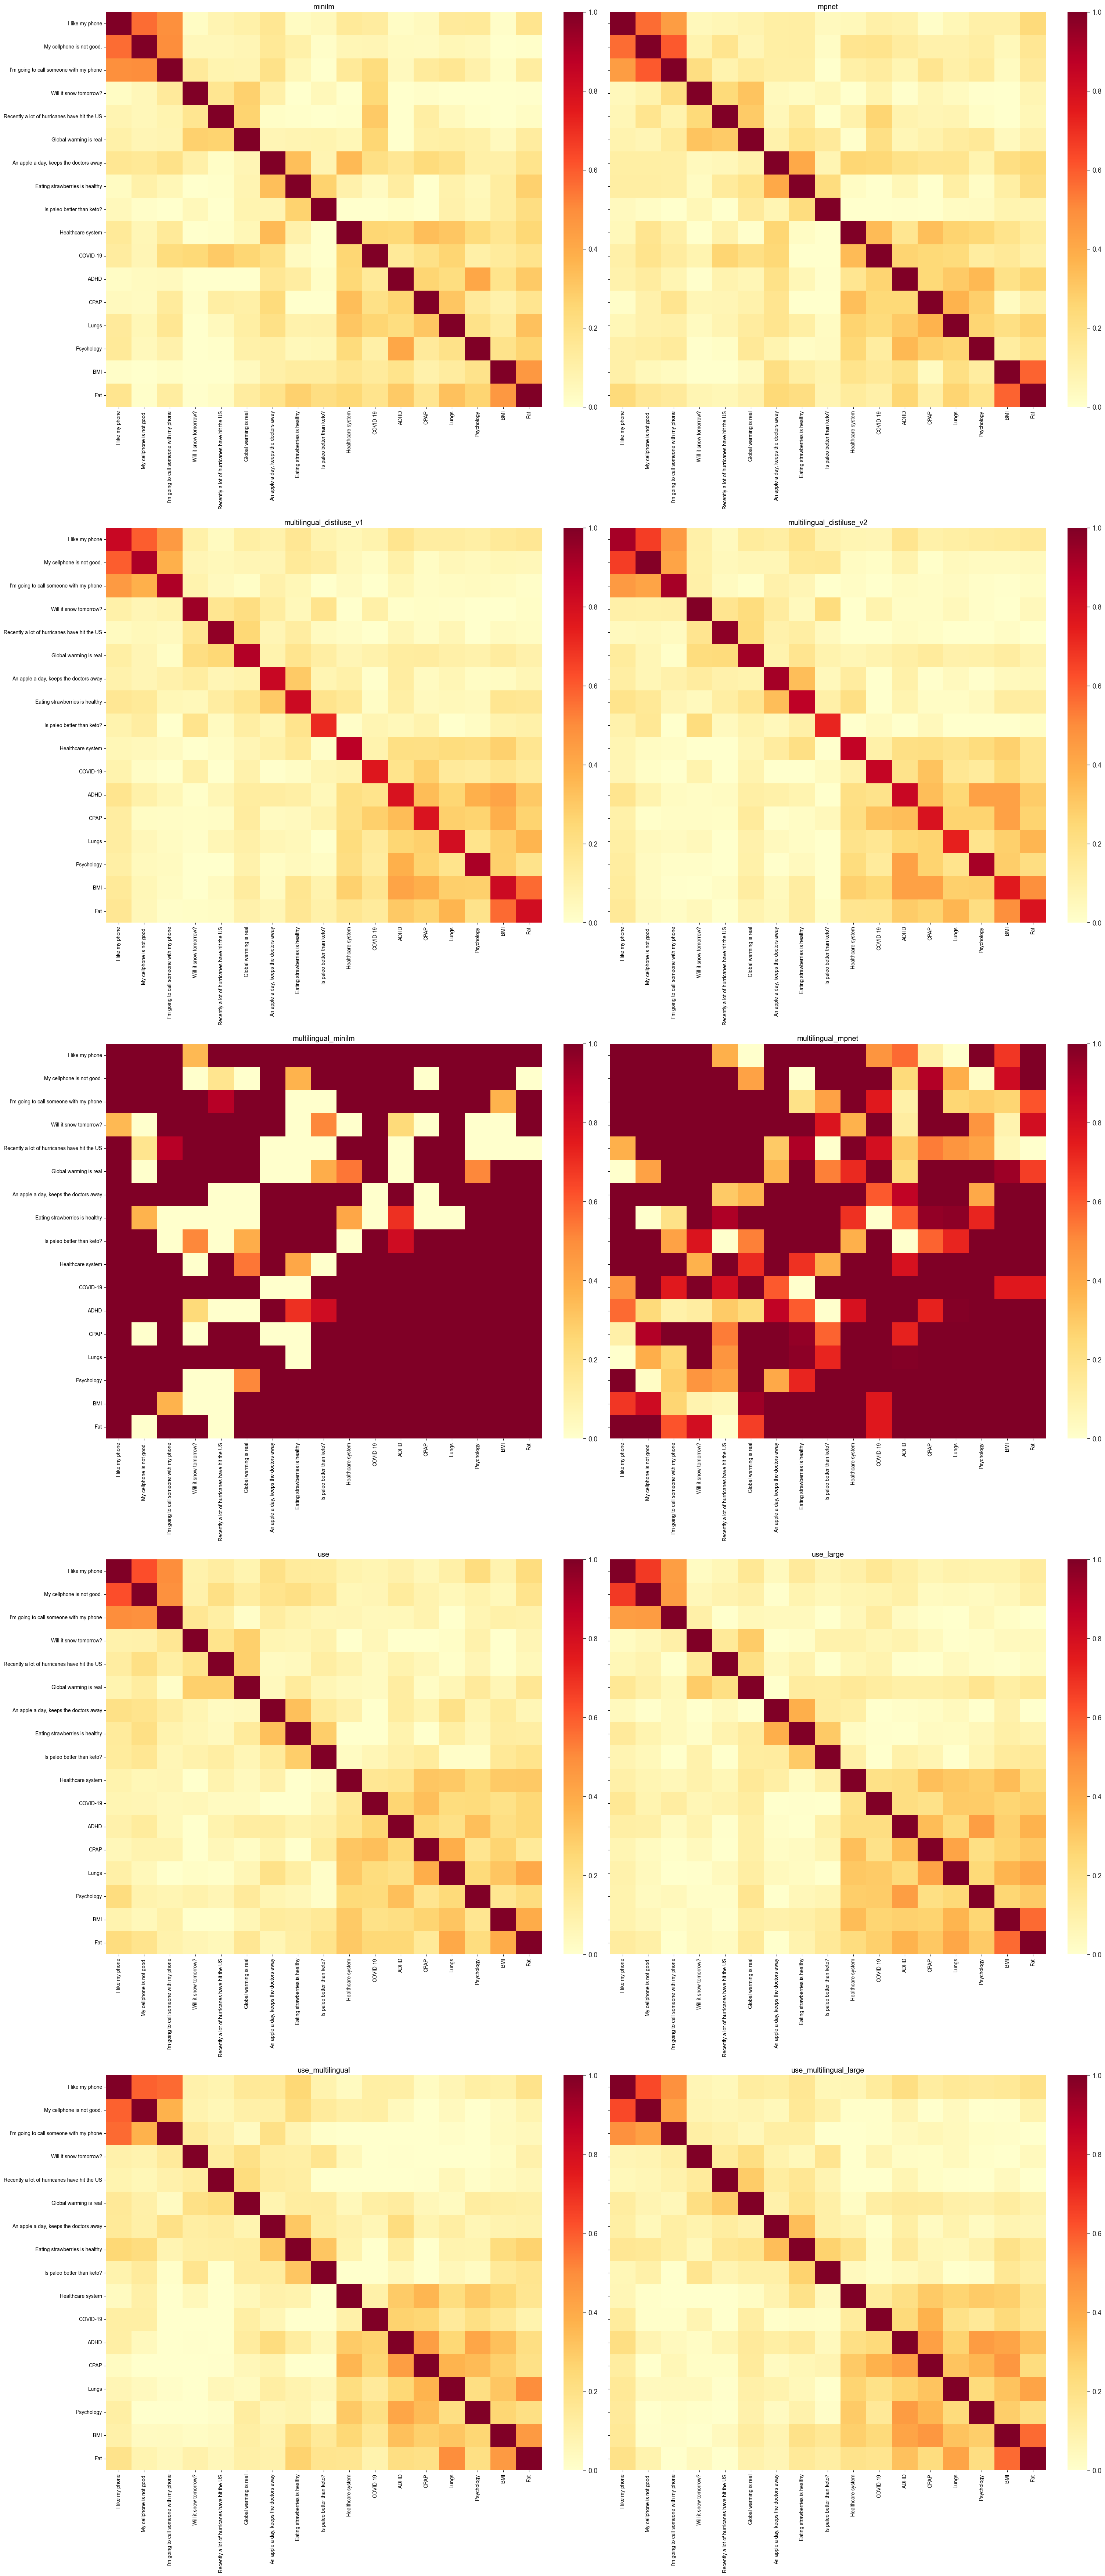

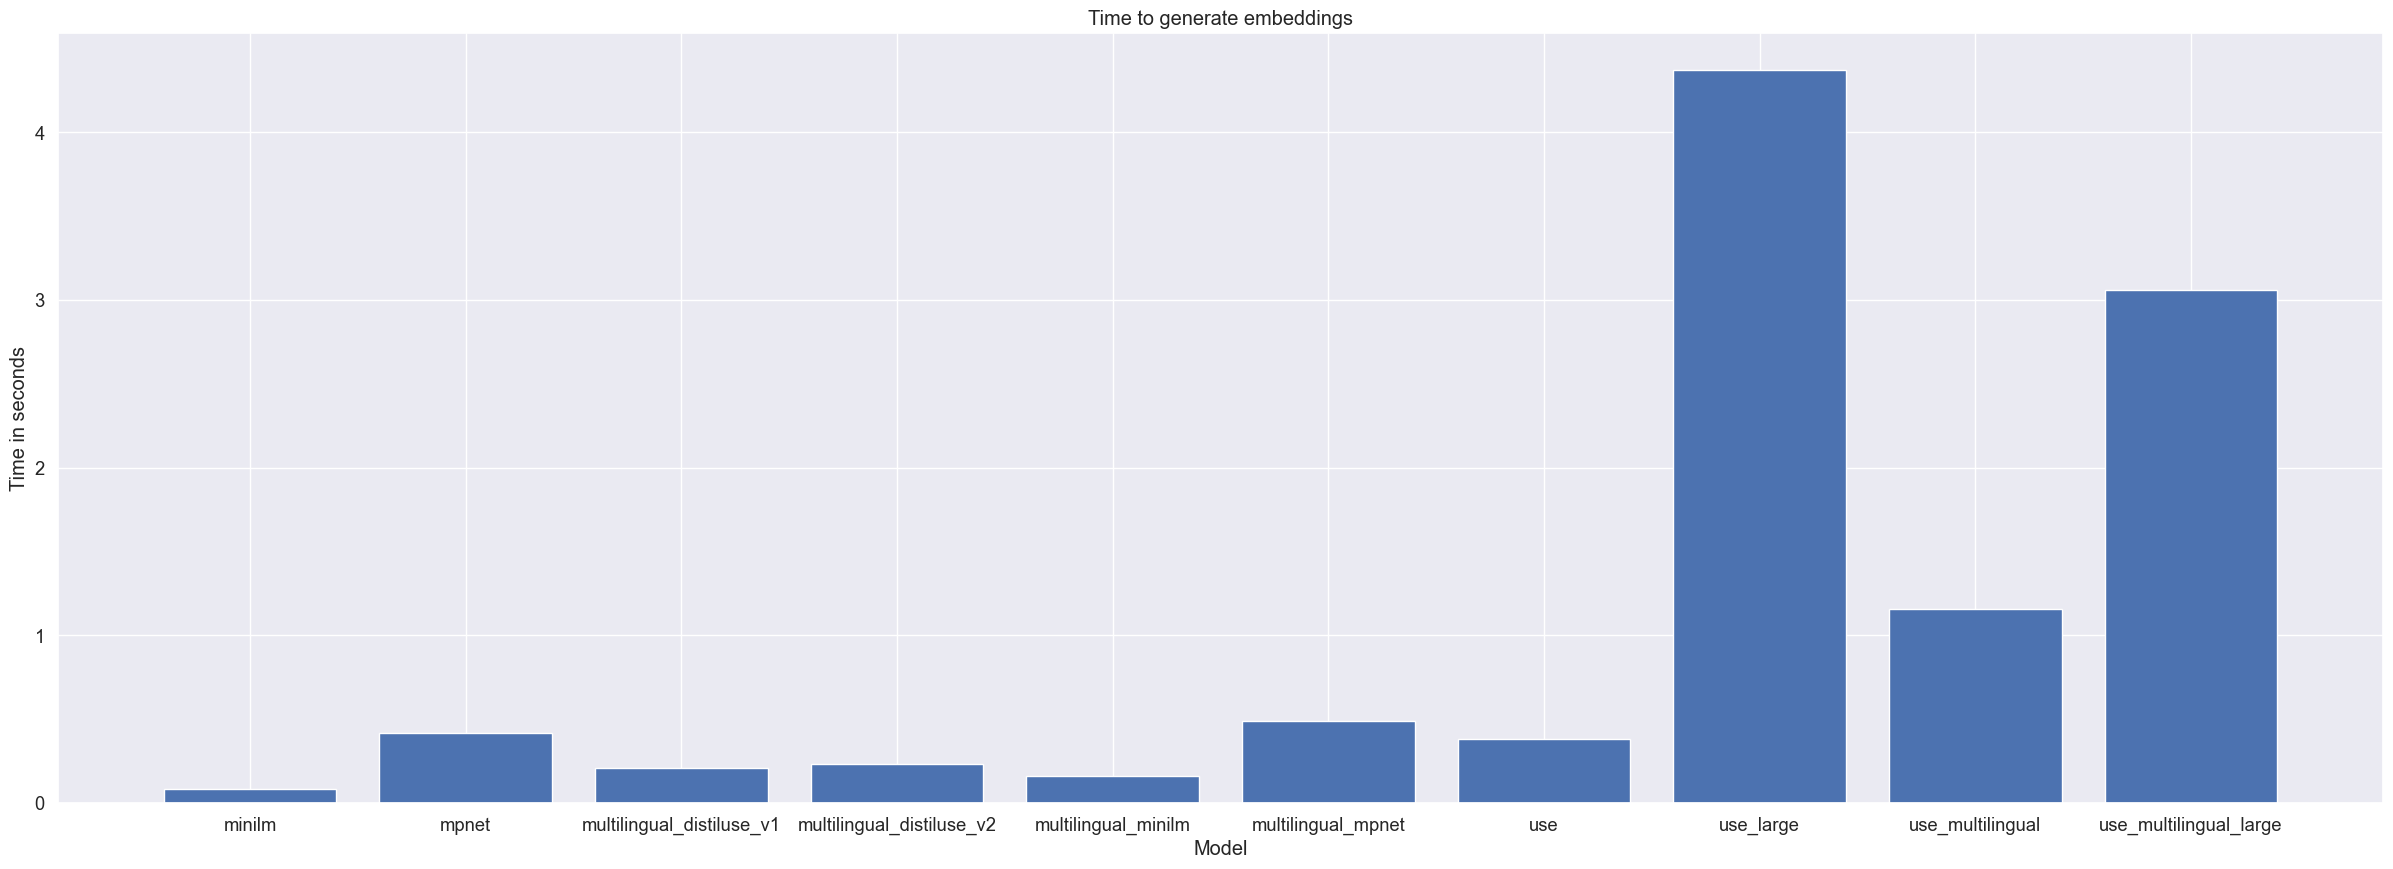

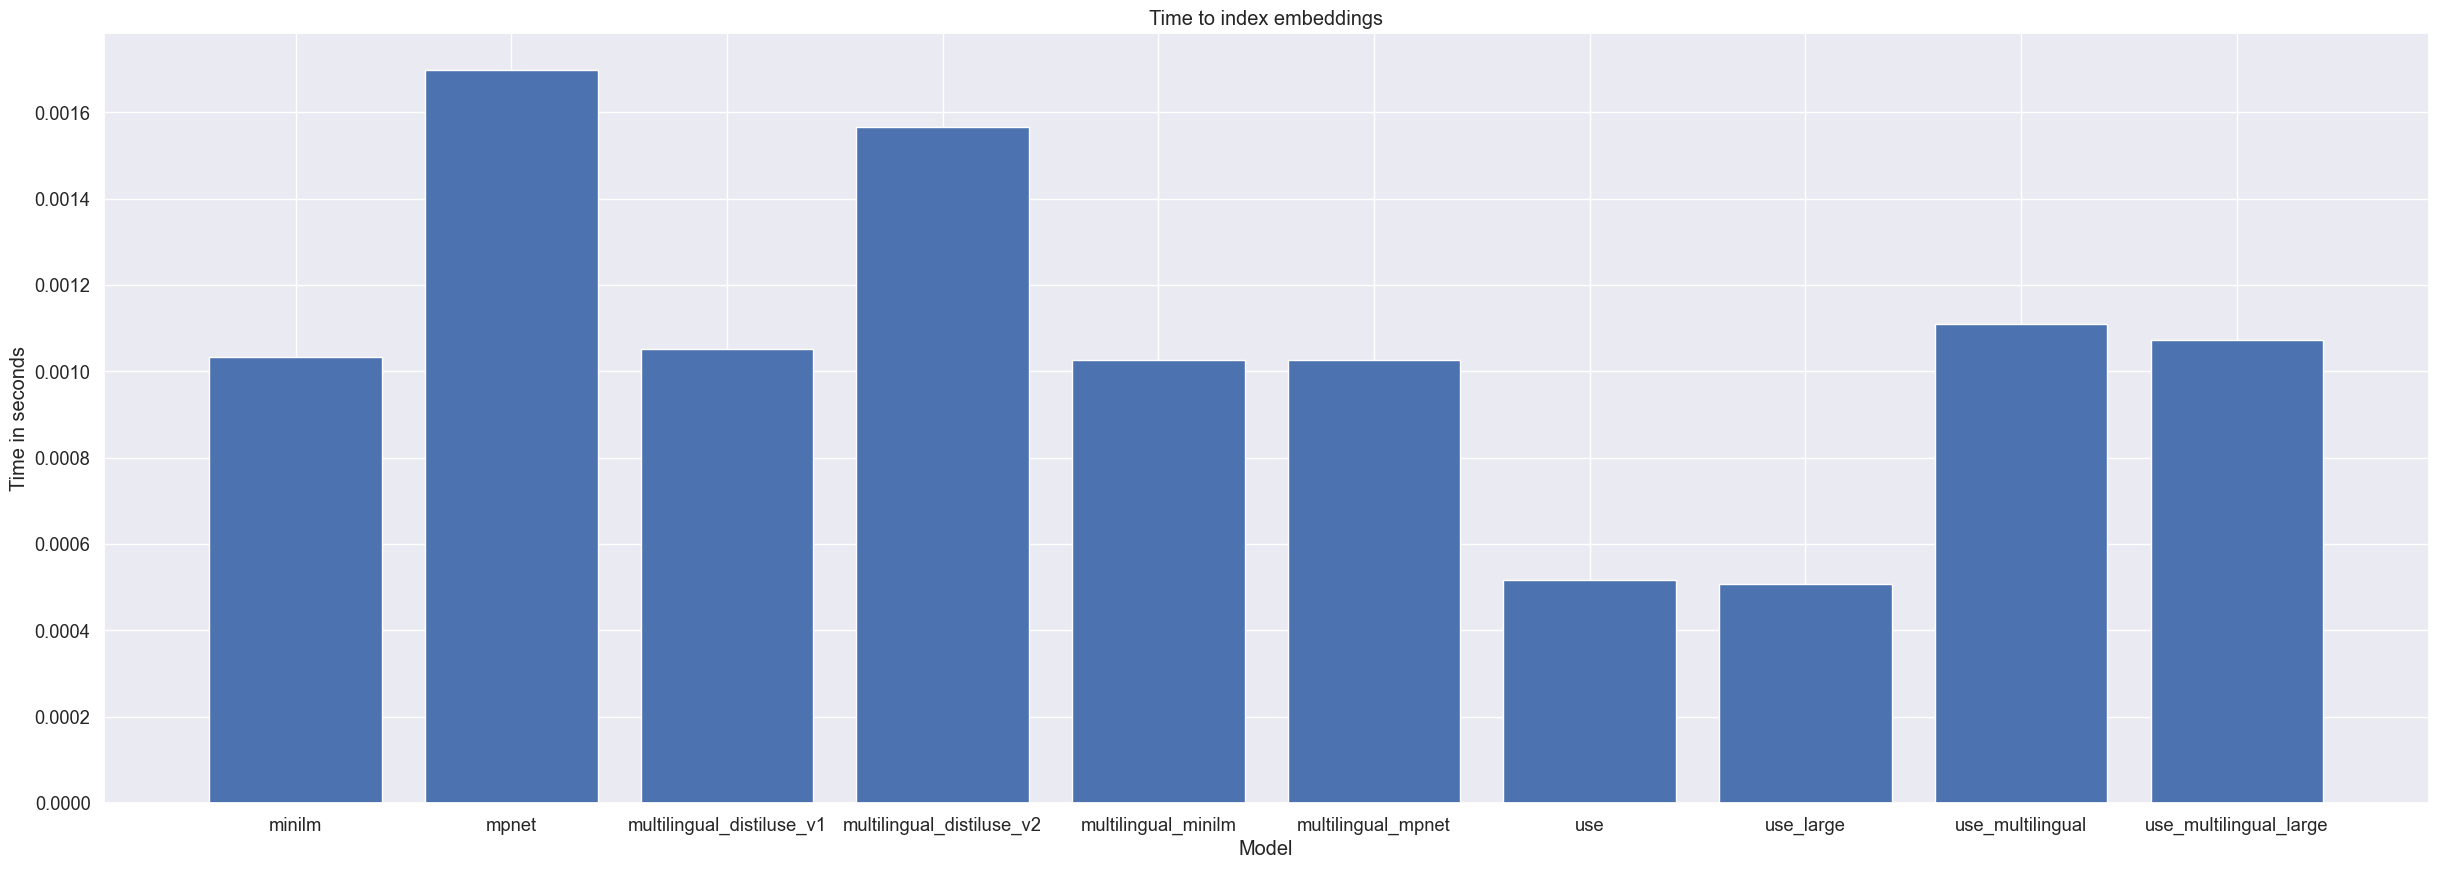

In [8]:
messages_sample = [
    "I like my phone",
    "My cellphone is not good.",
    "I'm going to call someone with my phone",
    "Will it snow tomorrow?",
    "Recently a lot of hurricanes have hit the US",
    "Global warming is real",
    "An apple a day, keeps the doctors away",
    "Eating strawberries is healthy",
    "Is paleo better than keto?",
    "Healthcare system",
    "COVID-19",
    "ADHD",
    "CPAP",
    "Lungs",
    "Psychology",
    "BMI",
    "Fat"
]

embeddings_sample = generate_embeddings(messages_sample)
plot_embeddings_heatmap(embeddings_sample, messages_sample)
plot_embeddings_timing(embeddings_sample, "time_encoding")
plot_embeddings_timing(embeddings_sample, "time_indexing")

## Búsqueda

### Generacion de resultados

In [9]:
def search(model, corpus, query, top_k=5, search_method="sbert", model_source="sbert"):
    result = {}
    
    start = time.time()
    if model_source == "sbert":
        query_embeddings = model.encode([query])
        corpus_embeddings = corpus["tensor"]
    elif model_source == "tf":
        query_embeddings = model([query]).numpy()
        corpus_embeddings = corpus["tensor"].numpy()
    
    if search_method == "sbert":
        hits = util.semantic_search(query_embeddings, corpus_embeddings, top_k=top_k)
        top_results = np.array([hit['corpus_id'] for hit in hits[0]])
    elif search_method == "torch":
        cos_scores = util.cos_sim(query_embeddings, corpus_embeddings)[0]
        top_results = torch.topk(cos_scores, k=top_k).indices.tolist()
    elif search_method == "numpy":
        cos_scores = util.cos_sim(query_embeddings, corpus_embeddings)[0]
        top_results = np.argpartition(-cos_scores, range(top_k))[0:top_k]
    elif search_method == "faiss":
        index = faiss.read_index("./indexes/index_embeddings_" + corpus["model"])
        top_results = index.search(query_embeddings, top_k)[1][0]
    elif search_method == "tf":
        cos_scores = tf.keras.losses.cosine_similarity(query_embeddings, corpus_embeddings, axis=1)
        top_results = tf.math.top_k(cos_scores, k=top_k)
        top_results = (top_results.indices.numpy(), top_results.values.numpy())[0]
    
    end = time.time()

    result = {
        "results": top_results,
        "time": end - start,
        "model": corpus["model"],
        "search_method": search_method,
    }
    return result

### Busqueda con todos los métodos de búsqueda

In [10]:
def search_all(query, k, embeddings):
    total = []
    
    results = []
    results.append(search(model_multilingual_distiluse_v1, embeddings[2], query, k, "sbert", model_source="sbert"))
    results.append(search(model_multilingual_distiluse_v1, embeddings[2], query, k, "torch", model_source="sbert"))
    results.append(search(model_multilingual_distiluse_v1, embeddings[2], query, k, "numpy", model_source="sbert"))
    results.append(search(model_multilingual_distiluse_v1, embeddings[2], query, k, "faiss", model_source="sbert"))
    results.append(search(model_multilingual_distiluse_v1, embeddings[2], query, k, "tf", model_source="sbert"))
    total.append(results)

    results = []
    results.append(search(model_multilingual_distiluse_v2, embeddings[3], query, k, "sbert", model_source="sbert"))
    results.append(search(model_multilingual_distiluse_v2, embeddings[3], query, k, "torch", model_source="sbert"))
    results.append(search(model_multilingual_distiluse_v2, embeddings[3], query, k, "numpy", model_source="sbert"))
    results.append(search(model_multilingual_distiluse_v2, embeddings[3], query, k, "faiss", model_source="sbert"))
    results.append(search(model_multilingual_distiluse_v2, embeddings[3], query, k, "tf", model_source="sbert"))
    total.append(results)
    
    results = []
    results.append(search(model_multilingual_minilm, embeddings[4], query, k, "sbert", model_source="sbert"))
    results.append(search(model_multilingual_minilm, embeddings[4], query, k, "torch", model_source="sbert"))
    results.append(search(model_multilingual_minilm, embeddings[4], query, k, "numpy", model_source="sbert"))
    results.append(search(model_multilingual_minilm, embeddings[4], query, k, "faiss", model_source="sbert"))
    results.append(search(model_multilingual_minilm, embeddings[4], query, k, "tf", model_source="sbert"))
    total.append(results)

    results = []
    results.append(search(model_multilingual_mpnet, embeddings[5], query, k, "sbert", model_source="sbert"))
    results.append(search(model_multilingual_mpnet, embeddings[5], query, k, "torch", model_source="sbert"))
    results.append(search(model_multilingual_mpnet, embeddings[5], query, k, "numpy", model_source="sbert"))
    results.append(search(model_multilingual_mpnet, embeddings[5], query, k, "faiss", model_source="sbert"))
    results.append(search(model_multilingual_mpnet, embeddings[5], query, k, "tf", model_source="sbert"))
    total.append(results)

    results = []
    results.append(search(model_use_multilingual, embeddings[8], query, k, "sbert", model_source="tf"))
    results.append(search(model_use_multilingual, embeddings[8], query, k, "torch", model_source="tf"))
    results.append(search(model_use_multilingual, embeddings[8], query, k, "numpy", model_source="tf"))
    results.append(search(model_use_multilingual, embeddings[8], query, k, "faiss", model_source="tf"))
    results.append(search(model_use_multilingual, embeddings[8], query, k, "tf", model_source="tf"))
    total.append(results)

    results = []
    results.append(search(model_use_multilingual_large, embeddings[9], query, k, "sbert", model_source="tf"))
    results.append(search(model_use_multilingual_large, embeddings[9], query, k, "torch", model_source="tf"))
    results.append(search(model_use_multilingual_large, embeddings[9], query, k, "numpy", model_source="tf"))
    results.append(search(model_use_multilingual_large, embeddings[9], query, k, "faiss", model_source="tf"))
    results.append(search(model_use_multilingual_large, embeddings[9], query, k, "tf", model_source="tf"))
    total.append(results)

    return total

### Mapa de calor de tiempos

In [11]:
def plot_search_timing(results):
    times = [[result["time"] for result in results] for results in results]
    plot = sns.heatmap(times, annot=True, fmt=".3f", xticklabels=["sbert", "torch", "numpy", "faiss", "tf"], yticklabels=["multilingual_distiluse_v1", "multilingual_distiluse_v2", "multilingual_minilm", "multilingual_mpnet", "use_multilingual", "use_multilingual_large"])
    plot.set_title("Time to search")
    plot.set_ylabel("Model")
    plot.set_xlabel("Search method")

## Resultados de búsqueda

In [12]:
def search_results(results, dataset, dataframe=True):
    labels = []
    for model_index, model in enumerate(results):
        for search_method_index, search_method in enumerate(model):
            label = {}
            label["model"] = results[model_index][0]["model"]
            label["search_method"] = search_method["search_method"]
            if (dataframe):
                titles = [dataset.iloc[[i]]["titulo_del_proyecto"].values[0] for i in search_method["results"]]
                aux_results = []
                for title_index, title in enumerate(titles):
                    aux_results.append((str(title_index + 1) + ". " + title))
                label["results"] = aux_results
            else:
                label["results"] = [str(index + 1) + ". " + dataset[i] for index, i in enumerate(search_method["results"])]
            
            labels.append(label)

    return pd.DataFrame.from_dict(labels)

### Prueba resultados

,model,search_method,results
0,multilingual_distiluse_v1,sbert,"[1. Fat, 2. Lungs, 3. ADHD, 4. BMI, 5. CPAP, 6. Psychology, 7. COVID-19, 8. I like my phone, 9. Healthcare system, 10. Eating strawberries is healthy]"
1,multilingual_distiluse_v1,torch,"[1. Fat, 2. Lungs, 3. ADHD, 4. BMI, 5. CPAP, 6. Psychology, 7. COVID-19, 8. I like my phone, 9. Healthcare system, 10. Eating strawberries is healthy]"
2,multilingual_distiluse_v1,numpy,"[1. Fat, 2. Lungs, 3. ADHD, 4. BMI, 5. CPAP, 6. Psychology, 7. COVID-19, 8. I like my phone, 9. Healthcare system, 10. Eating strawberries is healthy]"
3,multilingual_distiluse_v1,faiss,"[1. Fat, 2. ADHD, 3. Lungs, 4. BMI, 5. CPAP, 6. COVID-19, 7. I like my phone, 8. Psychology, 9. Healthcare system, 10. Eating strawberries is healthy]"
4,multilingual_distiluse_v1,tf,"[1. Recently a lot of hurricanes have hit the US, 2. Is paleo better than keto?, 3. My cellphone is not good., 4. An apple a day, keeps the doctors away, 5. I'm going to call someone with my phone, 6. Will it snow tomorrow?, 7. Global warming is real, 8. Eating strawberries is healthy, 9. Healthcare system, 10. I like my phone]"
5,multilingual_distiluse_v2,sbert,"[1. Fat, 2. Lungs, 3. BMI, 4. CPAP, 5. ADHD, 6. Psychology, 7. COVID-19, 8. I like my phone, 9. Healthcare system, 10. Global warming is real]"
6,multilingual_distiluse_v2,torch,"[1. Fat, 2. Lungs, 3. BMI, 4. CPAP, 5. ADHD, 6. Psychology, 7. COVID-19, 8. I like my phone, 9. Healthcare system, 10. Global warming is real]"
7,multilingual_distiluse_v2,numpy,"[1. Fat, 2. Lungs, 3. BMI, 4. CPAP, 5. ADHD, 6. Psychology, 7. COVID-19, 8. I like my phone, 9. Healthcare system, 10. Global warming is real]"
8,multilingual_distiluse_v2,faiss,"[1. Lungs, 2. Fat, 3. BMI, 4. CPAP, 5. ADHD, 6. Psychology, 7. COVID-19, 8. Healthcare system, 9. I like my phone, 10. Is paleo better than keto?]"
9,multilingual_distiluse_v2,tf,"[1. Recently a lot of hurricanes have hit the US, 2. Is paleo better than keto?, 3. An apple a day, keeps the doctors away, 4. I'm going to call someone with my phone, 5. My cellphone is not good., 6. Eating strawberries is healthy, 7. Will it snow tomorrow?, 8. Global warming is real, 9. Healthcare system, 10. I like my phone]"


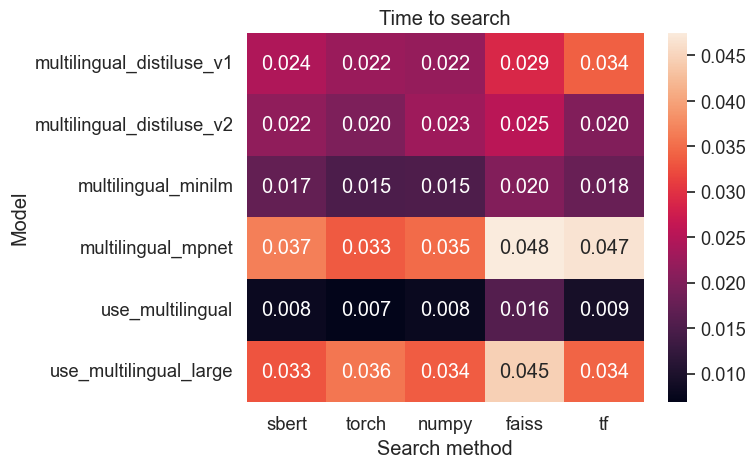

In [13]:
results_sample = search_all("Lluvia", 10, embeddings_sample)
plot_search_timing(results_sample)
results_df = search_results(results_sample, messages_sample, dataframe=False)
results_df

## Titulos investigaciones

### Importacion y limpieza de datos

In [14]:
inv_df = pd.read_excel('./xlsx/InvestigarPUJ.xlsx', sheet_name='Hoja1', converters={'ID PROYECTO':str})
siap_df = pd.read_excel('./xlsx/Descriptores SIAP 2023.xlsx', sheet_name='SIAP ', converters={'ID Proy':str})
inv_full_df = pd.read_excel('./xlsx/Descriptores SIAP 2023.xlsx', sheet_name='InvestigarPUJ', converters={'Id':str})

inv_full_df.drop("Año", axis=1, inplace=True)

datasets = [inv_df, siap_df, inv_full_df]
for dataset in datasets:
    dataset.replace('\\N', np.NaN, inplace=True)
    dataset.replace('null', np.NaN, inplace=True)
    dataset.replace('nan', np.NaN, inplace=True)
    dataset.replace('N/A', np.NaN, inplace=True)


merged = inv_df.merge(siap_df, left_on="ID PROYECTO", right_on="ID Proy", how="left")
df = merged.merge(inv_full_df, left_on="ID PROYECTO", right_on="Id", how="left")

df = df.groupby("ID PROYECTO").agg(lambda x: list(set(x))).applymap(lambda x: ', '.join(str(y) for y in x if str(y) != 'nan') if isinstance(x, list) else x)
df = df.reset_index()
df.columns = [unidecode(x.lower().strip().replace(" ", "_").replace("__", "_").replace(".", "")) for x in df.columns]

df.replace('', np.NaN, inplace=True)

df["descripcion"] = df["descripcion_x"].fillna("") + df["descripcion_y"].fillna("")

df.drop("titulo_x", axis=1, inplace=True)
df.drop("titulo_y", axis=1, inplace=True)
df.drop("id_proy", axis=1, inplace=True)
df.drop("id", axis=1, inplace=True)
df.drop("financiador", axis=1, inplace=True)
df.drop("tipo_propuesta", axis=1, inplace=True)
df.drop("descripcion_x", axis=1, inplace=True)
df.drop("descripcion_y", axis=1, inplace=True)
df.drop("id_propt", axis=1, inplace=True)
df.drop("f_inic_real", axis=1, inplace=True)
df.drop("f_final_real", axis=1, inplace=True)
df.drop("facultad", axis=1, inplace=True)
df.drop("departamento", axis=1, inplace=True)
df.drop("estado_proyecto", axis=1, inplace=True)
df.drop("nombre", axis=1, inplace=True)
df.drop("cantidad", axis=1, inplace=True)



#df[df["id_proyecto"] == "000000000007161"]
#df[df["id_proyecto"] == "004438"]
#df[df["id_proyecto"] == "20104"]

df = df[(df["tipo_de_propuesta"] == "ART") |
        (df["tipo_de_propuesta"] == "INN") |
        (df["tipo_de_propuesta"] == "NEW") |
        (df["tipo_de_propuesta"] == "PCA") |
        (df["tipo_de_propuesta"] == "PIS") |
        (df["tipo_de_propuesta"] == "PPC") |
        (df["tipo_de_propuesta"] == "PUE")]

df["corpus"] = df["titulo_del_proyecto"].fillna("") + " " + \
    df["nombre_facultad"].str.split().str[-1].fillna("") + " " + \
    df["nombre_del_departamento"].str.split().str[-1].fillna("") + " " + \
    df["descripcion"].fillna("") + " " + \
    df["resumen"].fillna("") + " " + \
    df["objetivos"].fillna("") + " " + \
    df["metodologia"].fillna("") + " " + \
    df["gran_area"].fillna("") + " " + \
    df["objetivo_socioeconomico"].fillna("") + " " + \
    df["palabras_clave"].fillna("")


df["corpus"] = df["corpus"].replace(r'\n',' ', regex=True).str.strip()

print(df.columns)
print(df.shape)

messages = df["corpus"].to_numpy()

Index(['id_proyecto', 'id_propuesta', 'tipo_de_propuesta', 'fecha_de_negociacion', 'ano', 'titulo_del_proyecto', 'fecha_inicial_real', 'fecha_final_real', 'nombre_facultad', 'nombre_del_departamento', 'convocatoria', 'nombre_patrocinador', 'nombre_grupo_de_investigacion', 'miembro_del_equipo', 'tipo_de_documento', 'numero_de_documento', 'nombres_y_apellidos', 'rol_en_el_proyecto', 'porcentaje_dedicacion', 'codigo_presupuesto', 'codigo_contrato_secre_juridica', 'valor_aprobado_patrocinador', 'contrapartida_terceros', 'contrapartida_rec_propi', 'contrapartida_rec_nuevo', 'rec_nuevos_unidade_academica', 'valor_contrapartida_total', 'valor_total', 'estado', 'codigo_tipo', 'convocatoria_nombre_corto', 'convocatoria', 'tipo_de_actividad', 'fecha_estimada_inicio', 'fecha_estimada_fin', 'id_empleado_responsable_puj', 'nombre_responsable_puj', 'departamento_responsable_puj', 'id_departamento_responsable_puj', 'facultad_responsable_puj', 'nombre_financiador_principal', 'resumen', 'objetivos',
  

In [15]:
df["corpus"].to_csv("./csv/corpus.csv", index=False)

### Descriptores

In [16]:
categories = df["nombre_facultad"].groupby(df["nombre_facultad"]).count().sort_values(ascending=False)
top20 = df["titulo_del_proyecto"].drop_duplicates().str.split(expand=True).stack().value_counts()[:20]

### Generacion embeddings

In [17]:
embeddings = generate_embeddings(messages)

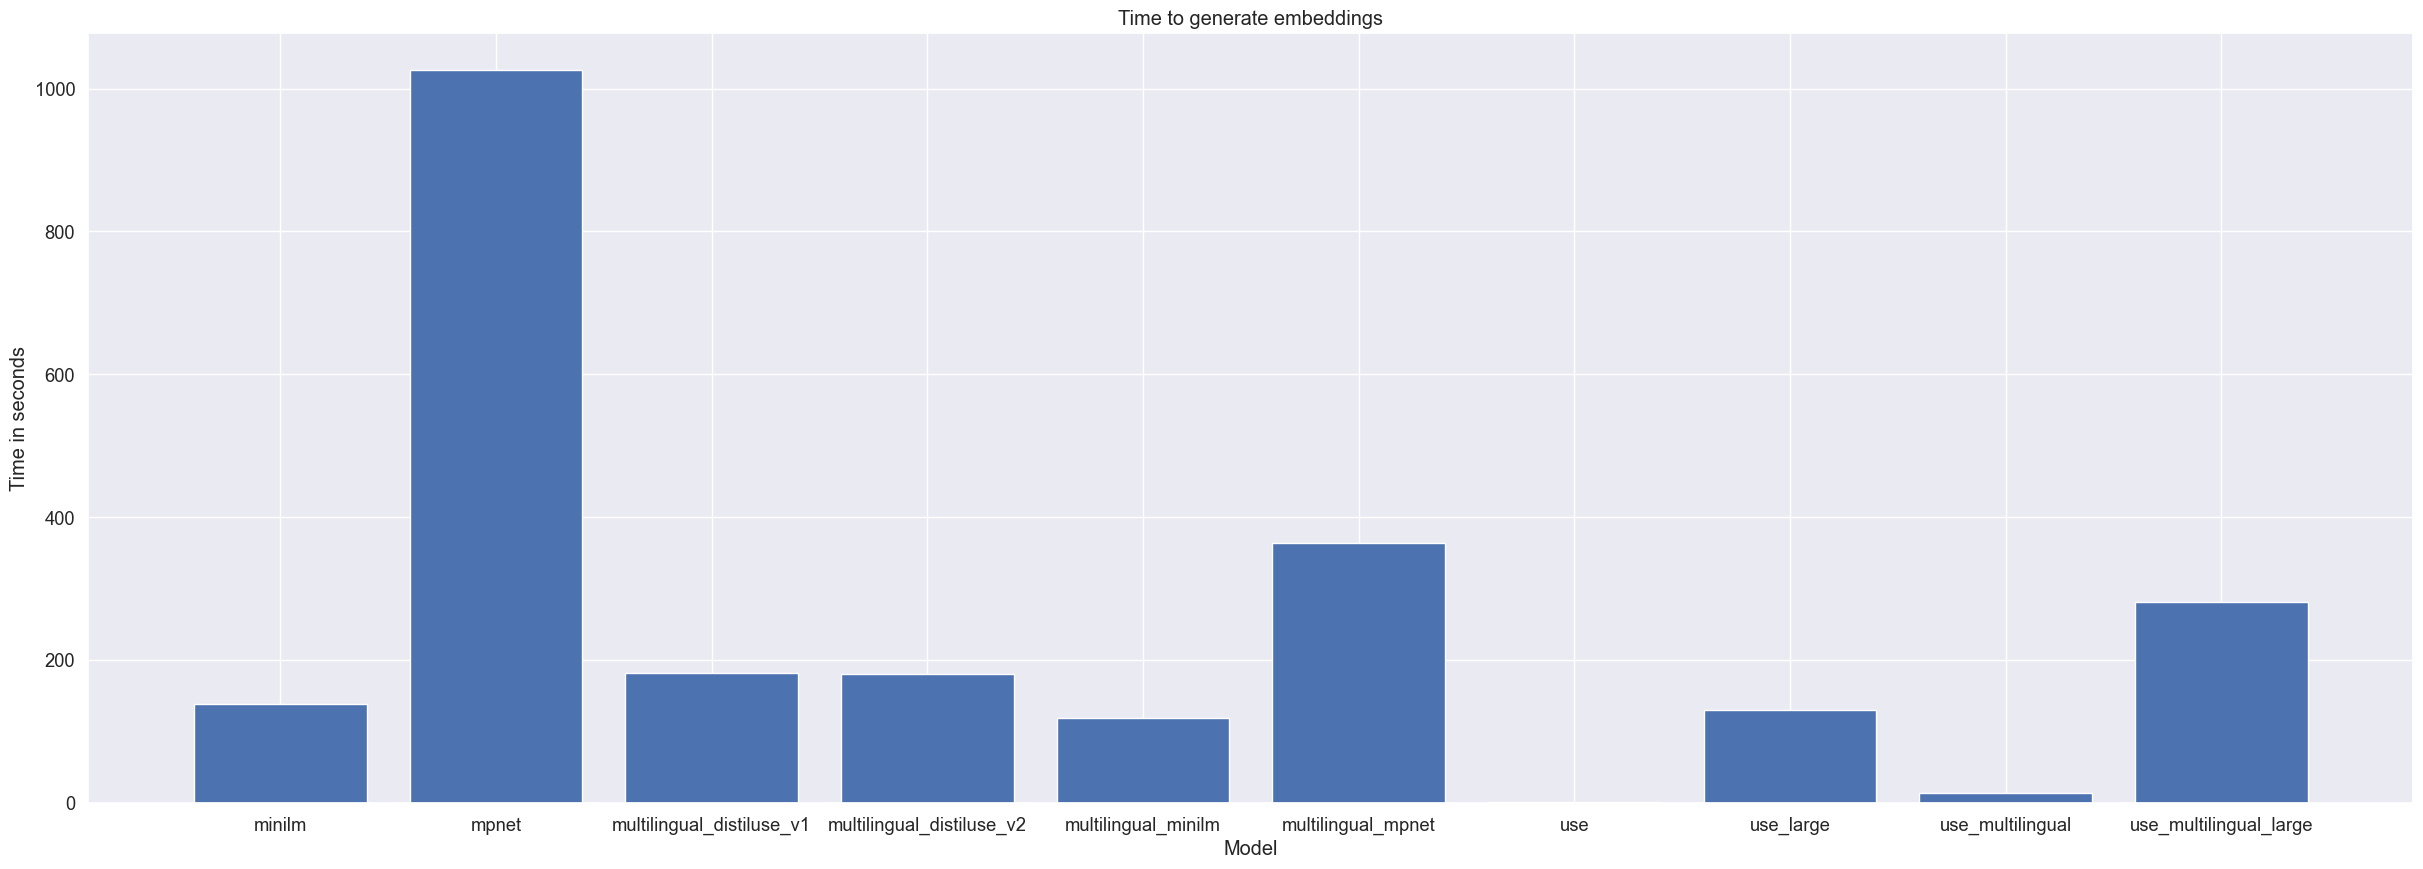

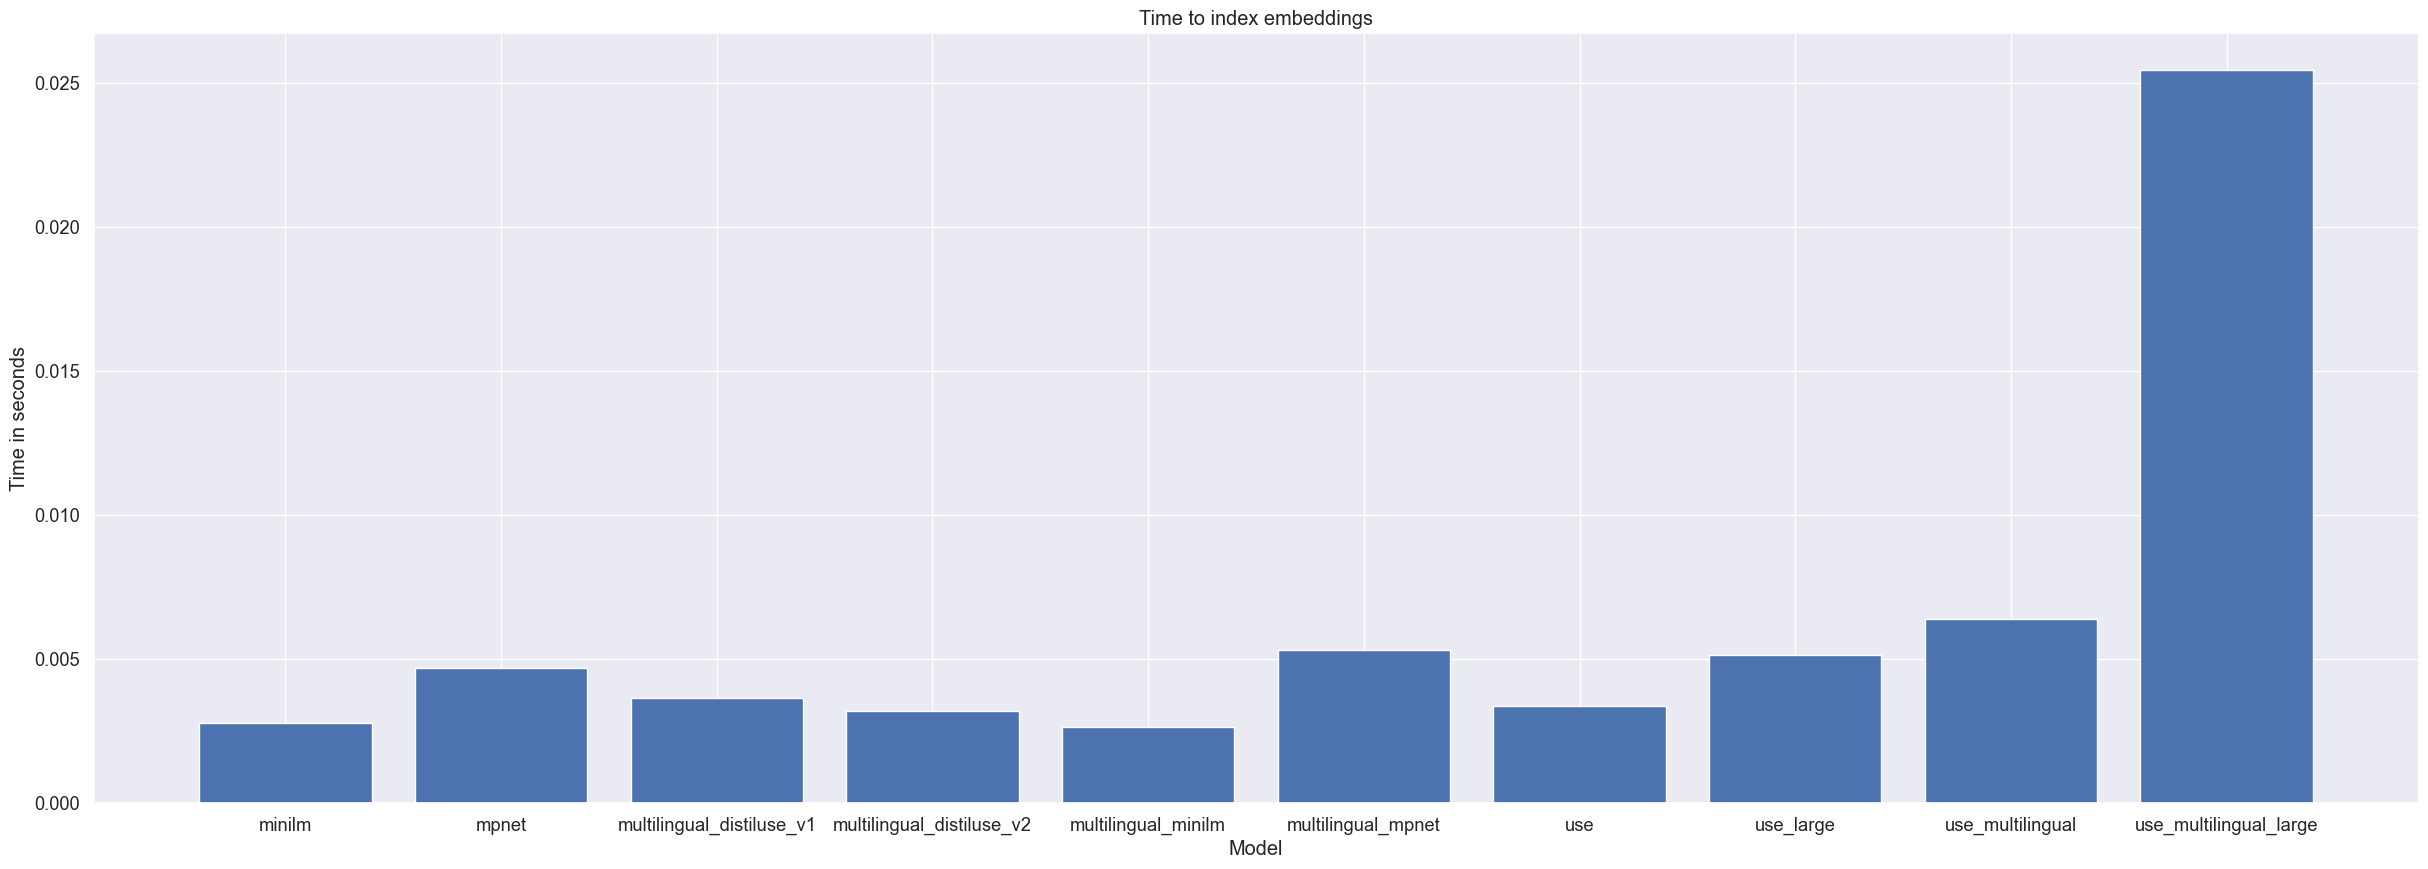

In [18]:
plot_embeddings_timing(embeddings, "time_encoding")
plot_embeddings_timing(embeddings, "time_indexing")

### Prueba busqueda

,model,search_method,results
15,multilingual_mpnet,sbert,"[1. De la memoria a la verdad: una apuesta de reconciliación., 2. Screening Violence: un estudio transnacional de los imaginarios del posconflicto, 3. Reglas en transición: una aproximación a las transformaciones en los arreglos institucionales para el manejo de los recursos naturales en el contexto del posconflicto en dos estudios de caso., 4. Desarrollo físico mecánico de una estructura con múltiples sensores para desminado humanitario, 5. Niños y niñas que se sueñan fuera de la guerra: Cartografía Social en Simití., 6. La verdad en las sentencias de justicia y paz., 7. Relatos del conflicto armado colombiano en los textos escolares de ciencias sociales, 8. Accountability sobre la violencia política y violaciones de derechos humanos: circunstancias, usos y efectos del registro de desapariciones forzadas. Lecciones desde una perspectiva comparativa en las Américas., 9. Aportes para un estado del arte y perspectivas futuras sobre experiencias y desafíos de la salud en el post-conflicto: una revisión narrativa y propuesta de un modelo de intervención, 10. Problemas de tierra y propiedad en la construcción del Estado en países post-conflicto. Caso Colombia. Proyecto colaborativo entre la Agencia de Cooperación Internacional del Japón (JICA) y la Pontificia Universidad Javeriana.]"
16,multilingual_mpnet,torch,"[1. De la memoria a la verdad: una apuesta de reconciliación., 2. Screening Violence: un estudio transnacional de los imaginarios del posconflicto, 3. Reglas en transición: una aproximación a las transformaciones en los arreglos institucionales para el manejo de los recursos naturales en el contexto del posconflicto en dos estudios de caso., 4. Desarrollo físico mecánico de una estructura con múltiples sensores para desminado humanitario, 5. Niños y niñas que se sueñan fuera de la guerra: Cartografía Social en Simití., 6. La verdad en las sentencias de justicia y paz., 7. Relatos del conflicto armado colombiano en los textos escolares de ciencias sociales, 8. Accountability sobre la violencia política y violaciones de derechos humanos: circunstancias, usos y efectos del registro de desapariciones forzadas. Lecciones desde una perspectiva comparativa en las Américas., 9. Aportes para un estado del arte y perspectivas futuras sobre experiencias y desafíos de la salud en el post-conflicto: una revisión narrativa y propuesta de un modelo de intervención, 10. Problemas de tierra y propiedad en la construcción del Estado en países post-conflicto. Caso Colombia. Proyecto colaborativo entre la Agencia de Cooperación Internacional del Japón (JICA) y la Pontificia Universidad Javeriana.]"
17,multilingual_mpnet,numpy,"[1. De la memoria a la verdad: una apuesta de reconciliación., 2. Screening Violence: un estudio transnacional de los imaginarios del posconflicto, 3. Reglas en transición: una aproximación a las transformaciones en los arreglos institucionales para el manejo de los recursos naturales en el contexto del posconflicto en dos estudios de caso., 4. Desarrollo físico mecánico de una estructura con múltiples sensores para desminado humanitario, 5. Niños y niñas que se sueñan fuera de la guerra: Cartografía Social en Simití., 6. La verdad en las sentencias de justicia y paz., 7. Relatos del conflicto armado colombiano en los textos escolares de ciencias sociales, 8. Accountability sobre la violencia política y violaciones de derechos humanos: circunstancias, usos y efectos del registro de desapariciones forzadas. Lecciones desde una perspectiva comparativa en las Américas., 9. Aportes para un estado del arte y perspectivas futuras sobre experiencias y desafíos de la salud en el post-conflicto: una revisión narrativa y propuesta de un modelo de intervención, 10. Problemas de tierra y propiedad en la construcción del Estado en países post-conflicto. Caso Colombia. Proyecto colaborativo entre la Agencia de Cooperación Internacional del Japón (JICA) y la Pontificia Universid

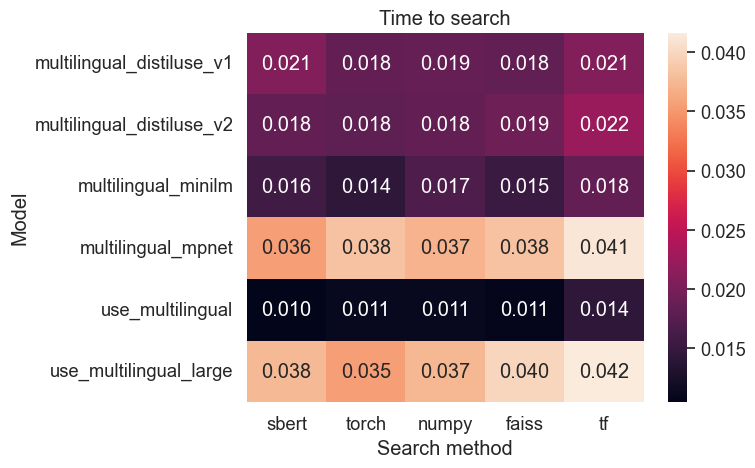

In [97]:
#Globulos rojos, LGBTI, Mujeres.
results = search_all("Guerra", 10, embeddings)
plot_search_timing(results)
results_df = search_results(results, df, True)
#results_df[results_df["model"].str.contains("multilingual_minilm") & results_df["search_method"].str.contains("sbert") | results_df["model"].str.contains("multilingual_mpnet") & results_df["search_method"].str.contains("sbert")]
results_df[results_df["model"].str.contains("multilingual_mpnet")]
#results_df